In [17]:
import os
import sys
import random
sys.path.append("../")

import dgl
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_theme();

from tqdm import tqdm
from utils import file_util

Using backend: pytorch


In [2]:
data_dir = "../data/reuters"
!ls $data_dir

crawl_wiki_concepts.log  doc_name_mentions.json  name_mention_links.json
data.ndjson		 entities_labels.json	 name_mentions
doc.csv			 label_encodes.json


In [3]:
doc_name_mentions = file_util.load_json(os.path.join(data_dir, "doc_name_mentions.json"))
name_mention_links = file_util.load_json(os.path.join(data_dir, "name_mention_links.json"))

Structure of `doc_name_mentions`:
```json
{doc_id: [name_mention_1, name_mention_2, ...]}
```

Structure of `name_mention_links`:
```json
{
    name_mention_id: 
    {
        "name_mention": List[name_mention_titles],
        "label": str,
        "parents": List[{"id": str, "level": int, "label": str, "path": str}]
    }
}
```

In [4]:
name_mention_mapping = {}
for id, info in name_mention_links.items():
    for text in info["name_mention"]:
        if text not in name_mention_mapping:
            name_mention_mapping[text] = set()
        name_mention_mapping[text].add(id)

In [5]:
name_mention_mapping["taxation"]

{'Q1964442', 'Q56317644', 'Q8161'}

## Concept Graph

1. Exclude name mention nodes, only considering concepts retrieved
2. Keep the largest component graph of each document. Hypothesis that the largest component holds the compromised concepts of the document

In [6]:
def create_concept_graph(doc_id):
    graph = nx.DiGraph()
    entities = []
    for name_mention in doc_name_mentions[doc_id]:
        for id in name_mention_mapping.get(name_mention, []):
            for parent in name_mention_links[id]["parents"]:
                path = parent["path"].split(" >> ")[1:]
                nx.add_path(graph, path)
                entities.extend(path)
    
    if not graph:
        return 0, 0, graph, entities
    num_nodes_before = len(graph.nodes)
    
    # Graph reduction
    largest_component_nodes = max(nx.connected_components(graph.to_undirected()), key=len)
    graph = graph.subgraph(largest_component_nodes)
    return num_nodes_before, len(graph.nodes), graph, entities

    # Prune nodes
#     node_central_scores = nx.algorithms.centrality.information_centrality(graph.to_undirected())
#     min_central_score = pd.Series(node_central_scores.values()).quantile(.85)
#     central_nodes = [node for node, score in node_central_scores.items() if score >= min_central_score]
#     graph = graph.subgraph(central_nodes)
#     num_nodes_after = len(graph.nodes)
#     return num_nodes_before, num_nodes_after, graph

Testing with sample: 17633
220 -> 97


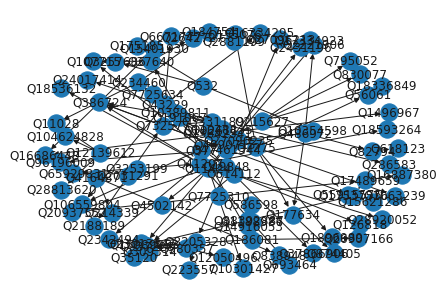

In [9]:
doc_ids = list(doc_name_mentions.keys())
sample_doc_id = random.sample(doc_ids, 1)[0]
print("Testing with sample:", sample_doc_id)

num_nodes_before, num_nodes_after, sample_graph, entities = create_concept_graph(sample_doc_id)
print(num_nodes_before, "->", num_nodes_after)
nx.draw(sample_graph, with_labels=True)

100%|██████████| 10788/10788 [11:03<00:00, 16.26it/s]


Graph nodes - edges: 5659 8423


count    5659.000000
mean        2.976851
std         4.519037
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       105.000000
dtype: float64

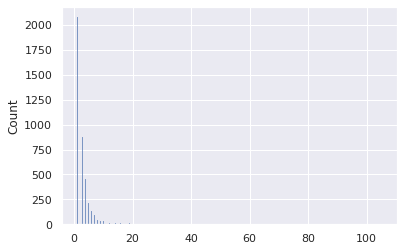

In [12]:
doc_entities = {}
pbar = tqdm(doc_ids)
total_graph = nx.DiGraph()
for doc_id in pbar:
    num_nodes_before, num_nodes_after, graph, entities = create_concept_graph(doc_id)
    doc_entities[doc_id] = entities
    total_graph = nx.compose(total_graph, graph)
    
print("Graph nodes - edges:", len(total_graph.nodes), len(total_graph.edges))
degree = pd.Series(dict(total_graph.degree()).values())
sns.histplot(degree);
degree.describe()

## Create Knowledge Graph

In [13]:
entities_ids = {e : i for i, e in enumerate(total_graph.nodes)}
document_ids = {d : i for i, d in enumerate(doc_name_mentions.keys())}

In [15]:
CvsC_edges, DvsC_edges = [], []
for u, v in total_graph.edges:
    edge = (entities_ids[u], entities_ids[v])
    CvsC_edges.append(edge)
for d in doc_entities:
    for u in doc_entities[d]:
        if u not in entities_ids:   # Ignore the pruned nodes
            continue
        edge = (document_ids[d], entities_ids[u])
        DvsC_edges.append(edge)

In [18]:
num_nodes_dict = {"document": len(document_ids), "concept": len(entities_ids)}
graph = dgl.heterograph(
    data_dict={
        ("document", "have", "concept"): DvsC_edges,
        ("concept", "belong", "document"): [(v, u) for u, v in DvsC_edges],
        ("concept", "is_child", "concept"): CvsC_edges,
        ("concept", "is_parent", "concept"): [(v, u) for u, v in CvsC_edges],
    }, 
    num_nodes_dict=num_nodes_dict
)

In [22]:
dgl.data.utils.save_graphs(os.path.join(data_dir, "graph.bin"), graph)
file_util.dump_json(entities_ids, os.path.join(data_dir, "entities_ids.json"))
file_util.dump_json(document_ids, os.path.join(data_dir, "document_ids.json"))